In [2]:
import os
import tensorflow as tf
print(tf.__version__)
os.chdir("TensorFlowTTS")
os.system("pip install .")
os.chdir("..")
import sys
sys.path.append("TensorFlowTTS/")


2.12.0-rc1


In [3]:
!pip install h5py

### (b) MelGAN + STFT Loss

In [4]:
print("Downloading MelGAN-STFT model...")
!gdown --id {"1WB5iQbk9qB-Y-wO8BU6S2TnRiu4VU5ys"} -O melgan.stft-2M.h5
!gdown --id {"1OqdrcHJvtXwNasEZP7KXZwtGUDXMKNkg"} -O melgan.stft_config.yml

c:\Users\sathishreddy\AppData\Local\Programs\Python\Python311\Lib\site-packages\gdown\cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1WB5iQbk9qB-Y-wO8BU6S2TnRiu4VU5ys
To: c:\Users\sathishreddy\Desktop\SpeechProcessing_EndSem_Proj\melgan.stft-2M.h5

  0%|          | 0.00/17.1M [00:00<?, ?B/s]
  3%|▎         | 524k/17.1M [00:01<00:47, 350kB/s]
  6%|▌         | 1.05M/17.1M [00:02<00:30, 535kB/s]
  9%|▉         | 1.57M/17.1M [00:03<00:28, 544kB/s]
 12%|█▏        | 2.10M/17.1M [00:03<00:23, 637kB/s]
 15%|█▌        | 2.62M/17.1M [00:04<00:22, 650kB/s]
 18%|█▊        | 3.15M/17.1M [00:05<00:21, 650kB/s]
 21%|██▏       | 3.67M/17.1M [00:06<00:25, 524kB/s]
 24%|██▍       | 4.19M/17.1M [00:07<00:26, 493kB/s]
 28%|██▊       | 4.72M/17.1M [00:08<00:24, 510kB/s]
 31%|███       | 5.24M/17.1M [00:09<00:21, 556kB/s]
 34%|███▎    

## Load Model

In [5]:
import tensorflow as tf

import yaml
import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd

from tensorflow_tts.inference import TFAutoModel
from tensorflow_tts.inference import AutoConfig
from tensorflow_tts.inference import AutoProcessor

c:\Users\sathishreddy\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\sathishreddy\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### (a) Tacotron 2

In [6]:
tacotron2 = TFAutoModel.from_pretrained("tensorspeech/tts-tacotron2-ljspeech-en", name="tacotron2")

c:\Users\sathishreddy\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:649: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


### (b) FastSpeech

In [7]:
fastspeech = TFAutoModel.from_pretrained("tensorspeech/tts-fastspeech-ljspeech-en", name="fastspeech")

### (c) FastSpeech2

In [8]:
fastspeech2 = TFAutoModel.from_pretrained("tensorspeech/tts-fastspeech2-ljspeech-en", name="fastspeech2")

### (d) MelGAN Original

In [9]:
melgan = TFAutoModel.from_pretrained("tensorspeech/tts-melgan-ljspeech-en", name="melgan")

### (e) MelGAN STFT

In [10]:
melgan_stft_config = AutoConfig.from_pretrained('TensorFlowTTS/examples/melgan_stft/conf/melgan_stft.v1.yaml')
melgan_stft = TFAutoModel.from_pretrained(
    config=melgan_stft_config,
    pretrained_path="melgan.stft-2M.h5",
    name="melgan_stft"
)

### (f) Multi-band MelGAN

In [11]:
mb_melgan = TFAutoModel.from_pretrained("tensorspeech/tts-mb_melgan-ljspeech-en", name="mb_melgan")

In [12]:
processor = AutoProcessor.from_pretrained("tensorspeech/tts-tacotron2-ljspeech-en")

In [13]:
def do_synthesis(input_text, text2mel_model, vocoder_model, text2mel_name, vocoder_name):
  input_ids = processor.text_to_sequence(input_text)

  # text2mel part
  if text2mel_name == "TACOTRON":
    _, mel_outputs, stop_token_prediction, alignment_history = text2mel_model.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        tf.convert_to_tensor([len(input_ids)], tf.int32),
        tf.convert_to_tensor([0], dtype=tf.int32)
    )
  elif text2mel_name == "FASTSPEECH":
    mel_before, mel_outputs, duration_outputs = text2mel_model.inference(
        input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
        speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    )
  elif text2mel_name == "FASTSPEECH2":
    mel_before, mel_outputs, duration_outputs, _, _ = text2mel_model.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
        speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
        f0_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
        energy_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    )
  else:
    raise ValueError("Only TACOTRON, FASTSPEECH, FASTSPEECH2 are supported on text2mel_name")

  # vocoder part
  if vocoder_name == "MELGAN" or vocoder_name == "MELGAN-STFT":
    audio = vocoder_model(mel_outputs)[0, :, 0]
  elif vocoder_name == "MB-MELGAN":
    audio = vocoder_model(mel_outputs)[0, :, 0]
  else:
    raise ValueError("Only MELGAN, MELGAN-STFT and MB_MELGAN are supported on vocoder_name")

  if text2mel_name == "TACOTRON":
    return mel_outputs.numpy(), alignment_history.numpy(), audio.numpy()
  else:
    return mel_outputs.numpy(), audio.numpy()

def visualize_attention(alignment_history):
  import matplotlib.pyplot as plt

  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111)
  ax.set_title(f'Alignment steps')
  im = ax.imshow(
      alignment_history,
      aspect='auto',
      origin='lower',
      interpolation='none')
  fig.colorbar(im, ax=ax)
  xlabel = 'Decoder timestep'
  plt.xlabel(xlabel)
  plt.ylabel('Encoder timestep')
  plt.tight_layout()
  plt.show()
  plt.close()

def visualize_mel_spectrogram(mels):
  mels = tf.reshape(mels, [-1, 80]).numpy()
  fig = plt.figure(figsize=(10, 8))
  ax1 = fig.add_subplot(311)
  ax1.set_title(f'Predicted Mel-after-Spectrogram')
  im = ax1.imshow(np.rot90(mels), aspect='auto', interpolation='none')
  fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
  plt.show()
  plt.close()

In [14]:
input_text = "Kashmir is India's paradise."

### (a) Tacotron2 + MELGAN

In [15]:
mels, alignment_history, audios = do_synthesis(input_text, tacotron2, melgan, "TACOTRON", "MELGAN")
#visualize_attention(alignment_history[0])
#visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)

### (b) Tacotron2 + MELGAN-STFT

In [16]:
mels, alignment_history, audios = do_synthesis(input_text, tacotron2, melgan_stft, "TACOTRON", "MELGAN-STFT")
#visualize_attention(alignment_history[0])
#visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)

### (c) Tacotron2 + MB-MELGAN

In [17]:
mels, alignment_history, audios = do_synthesis(input_text, tacotron2, mb_melgan, "TACOTRON", "MB-MELGAN")
#visualize_attention(alignment_history[0])
#visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)

### (d) FastSpeech + MB-MELGAN

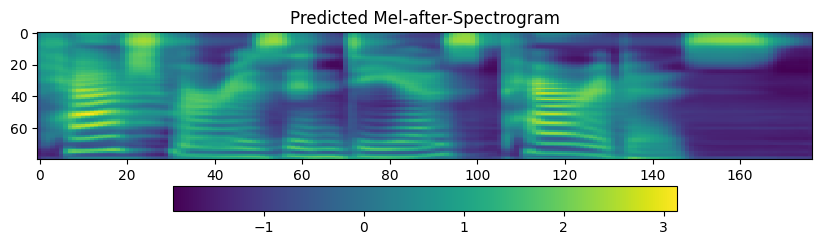

In [18]:
mels, audios = do_synthesis(input_text, fastspeech, mb_melgan, "FASTSPEECH", "MB-MELGAN")
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)

### (e) FastSpeech + MELGAN-STFT

In [19]:
mels, audios = do_synthesis(input_text, fastspeech, melgan_stft, "FASTSPEECH", "MELGAN-STFT")
#visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)

### (f) FastSpeech + MELGAN

In [20]:
mels, audios = do_synthesis(input_text, fastspeech, melgan, "FASTSPEECH", "MELGAN")
#visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)

### (g) FastSpeech2 + MB-MELGAN

In [21]:
mels, audios = do_synthesis(input_text, fastspeech2, mb_melgan, "FASTSPEECH2", "MB-MELGAN")
#visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)

### (h) FastSpeech2 + MELGAN-STFT

In [22]:
mels, audios = do_synthesis(input_text, fastspeech2, melgan_stft, "FASTSPEECH2", "MELGAN-STFT")
#visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)

### (i) FastSpeech2 + MELGAN

In [23]:
mels, audios = do_synthesis(input_text, fastspeech2, melgan, "FASTSPEECH2", "MELGAN")
#visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)

In [24]:
!pip install streamlit